In [120]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.aqua.components.optimizers import COBYLA, SLSQP, SPSA
import math
import random
import numpy as np
from numpy import pi
import time
import itertools
import matplotlib.pyplot as plt


In [2]:
def prepare_initial_state(theta, phase):
    """ Prepare initial state """
    return (math.cos(theta) * (1 + 0j),
        (math.sin(theta) * math.e**(1j * phase) + 0 + 0j))

In [3]:
def convert_counts_to_final_result(counts) -> int:
    """ Convert the execution result to the final measured value: 0 or 1 """
    if "0" in counts:
        return 0
    return 1

In [4]:
def set_random_eta(eta0, eta1):
    """ return a random choice from eta0 and eta1 with the correspondent key name """
    eta_value = random.choice([eta0, eta1])
    if eta_value == eta0:
        return eta_value, 0
    return eta_value, 1

In [5]:
def compute_damping_channel(theta, phase, eta, phi_rx, phi_ry, backend) -> int:
    """ one-time execution of the amplitude damping circuit using the passed parameters 
        Returns: the execution measured result: either 0 or 1
    """
    qreg_q = QuantumRegister(2, 'q')
    creg_c = ClassicalRegister(1, 'c')

    initial_state = prepare_initial_state(theta, phase)

    circuit = QuantumCircuit(qreg_q, creg_c)
    circuit.initialize([initial_state[0],
                        initial_state[1]], qreg_q[0])
    circuit.reset(qreg_q[1])
    circuit.cry(eta, qreg_q[0], qreg_q[1])
    circuit.cx(qreg_q[1], qreg_q[0])
    circuit.rx(phi_rx, qreg_q[0])
    circuit.ry(phi_ry, qreg_q[0])
    circuit.measure(qreg_q[0], creg_c[0])

    counts = execute(circuit, backend, shots=1).result().get_counts(circuit)
    return convert_counts_to_final_result(counts)

In [6]:
def compute_random_damping_channel(configuration, backend):
    """ run a one-time execution on the given backend device randomly selectiong the eta to be used and return the measured result """
    eta_value, eta_used = set_random_eta(configuration['eta0'], configuration['eta1'])
    result = compute_damping_channel(configuration['theta'], configuration['phase'], eta_value, configuration['phi_rx'], configuration['phi_ry'], backend)

    return {
        "result": result,
        "eta_used": eta_used
    }

## A sample execution

In [7]:
# a simple execution
backend = backend=Aer.get_backend('qasm_simulator')

theta = pi
phase = pi
phi_rx = 0
phi_ry = 0
eta0 = pi/2
eta1 = 0

configuration = {
    "theta": theta,
    "phase": phase,
    "phi_rx": phi_rx,
    "phi_ry": phi_ry,
    "eta0": eta0,
    "eta1": eta1
}

In [11]:
real_result = compute_random_damping_channel(configuration, backend)
real_result

{'result': 0, 'eta_used': 1}

In [12]:
def guess_eta_used(real_measured_result):
    """ Decides which eta was used on the real execution.
        It is a silly guess.
        It returns the eta used is 0 when the measured result is 0, and 1 otherwise
    """
    return real_measured_result

In [13]:
def check_value(real_eta, guess_eta): 
    if real_eta == guess_eta: return 1
    return 0

In [15]:
def play_and_guess_one_case(configuration, backend):
    """ Execute a real execution with a random eta from the two passed, 
        guess which one was used on the exection and
        check the result.
        Returns 1 on success (it was a correct guess) or 0 on fail (it was an incorrect guess) 
    """
    real_result = compute_random_damping_channel(configuration, backend)
    guess_eta = guess_eta_used(real_result['result'])
    return check_value(real_result['eta_used'], guess_eta)

In [33]:
configuration = {
    "theta": theta,
    "phase": phase,
    "phi_rx": phi_rx,
    "phi_ry": phi_ry,
    "eta0": eta0,
    "eta1": eta1
}
play_and_guess_one_case(configuration, backend)

1

## Creating our cost function to be the one that has to be maximized

In [16]:
def play_one_configuration(configuration, backend, plays=1000):
    """ Play the play_and_guess game for the number of plays for the configuration of input parameters.
        Returns the average success probability for all the plays with the given configuration. 
    """
    success_counts = 0
    for play in range(plays):
        success_counts += play_and_guess_one_case(configuration, backend)
    return success_counts/plays

In [149]:
def cost_function(params):
    """ Computes the cost of running a specific configuration.
        Cost is computed as 1 (perfect probability) - given probability [0,1]
    """
    backend = backend=Aer.get_backend('qasm_simulator')

    configuration = {
        "theta": params[0],
        "phase": params[1],
        "phi_rx": params[2],
        "phi_ry": params[3],
        "eta0": GLOBAL_ETA0,
        "eta1": GLOBAL_ETA1
    }
    return 1 - play_one_configuration(configuration, backend, plays=100)

### A sample execution of 1000 plays

In [131]:
# a simple execution
backend = backend=Aer.get_backend('qasm_simulator')

configuration = {
    "theta": pi,
    "phase": 0,
    "phi_rx": 0,
    "phi_ry": 0,
    "eta0": pi/2,
    "eta1": 0
}
play_one_configuration(configuration, backend)

0.529

In [150]:
config_params = [pi, 0, 0, 0]

GLOBAL_ETA0=0
GLOBAL_ETA1=0
cost_function(config_params)

0.0

In [161]:
def compute_best_configuration(optimizer_algorithm='COBYLA', optimizer_iterations=100, step_size=pi/10, iterations=1):
    optimizer = COBYLA(maxiter=optimizer_iterations, rhobeg=step_size)
    
    if optimizer_algorithm == 'SLSQP':
        optimizer = SLSQP(maxiter=optimizer_iterations, eps=step_size)
    if optimizer_algorithm == 'SPSA':
        optimizer = SPSA(maxiter=optimizer_iterations, c0=step_size)

    # Create the initial parameters and set the bounds
    initial_params = [0, 0, 0, 0]
    variable_bounds = [
                        (0, 2*pi), # theta
                        (0, 2*pi), # phase
                        (0, 2*pi), # rx
                        (0, 2*pi)  # ry
                        ]
    best_probability = 0
    best_configuration = []
    for i in range(iterations):
        ret = optimizer.optimize(num_vars=len(initial_params), 
                                objective_function=cost_function, 
                                variable_bounds=variable_bounds,
                                initial_point=initial_params)
        print("Best Average Probability:", 1 - ret[1])
        if (1-ret[1]) > best_probability:
            best_probability = 1-ret[1]
            best_configuration = ret[0]

    # Print results
    print("Final Best Average Probability:", best_probability)
    print("Parameters Found: " + u"\u03B8" + " = " + str(int(math.degrees(best_configuration[0]))) + u"\u00B0" +
                            ", Phase = " + str(int(math.degrees(best_configuration[1]))) + u"\u00B0" + 
                            ", " + u"\u03D5" + "rx = " + str(int(math.degrees(best_configuration[2]))) + u"\u00B0" + 
                            ", " + u"\u03D5" + "ry = " + str(int(math.degrees(best_configuration[3]))) + u"\u00B0" +
                            ", " + u"\u03B7" + u"\u2080" + " = " + str(int(math.degrees(GLOBAL_ETA0))) + u"\u00B0" + 
                            ", " + u"\u03B7" + u"\u2081" + " = " + str(int(math.degrees(GLOBAL_ETA1))) + u"\u00B0")
    return {
        "best_probability": best_probability,
        "best_configuration": best_configuration
    }


In [162]:
GLOBAL_ETA0=pi/2
GLOBAL_ETA1=0
compute_best_configuration(optimizer_algorithm='COBYLA', optimizer_iterations=200, iterations=2)

Best Average Probability: 0.57
Best Average Probability: 0.4099999999999999
Final Best Average Probability: 0.57
Parameters Found: θ = 17°, Phase = 16°, ϕrx = 19°, ϕry = -1°, η₀ = 90°, η₁ = 0°


{'best_probability': 0.57,
 'best_configuration': array([ 0.30557675,  0.28508776,  0.33240074, -0.02743364])}

In [163]:
GLOBAL_ETA0=pi/2
GLOBAL_ETA1=0
compute_best_configuration(optimizer_algorithm='SLSQP', optimizer_iterations=200, iterations=2)

Best Average Probability: 0.49
Best Average Probability: 0.55
Final Best Average Probability: 0.55
Parameters Found: θ = 0°, Phase = 0°, ϕrx = 0°, ϕry = 0°, η₀ = 90°, η₁ = 0°


{'best_probability': 0.55, 'best_configuration': array([0., 0., 0., 0.])}

In [156]:
compute_best_configuration(optimizer_algorithm='SPSA', optimizer_iterations=50, iterations=1)

Best Average Probability: 0.69
Final Best Average Probability: 0.69
Parameters Found: θ = 544°, Phase = -416°, ϕrx = 141°, ϕry = 841°, η₀ = 0°, η₁ = 0°


{'best_probability': 0.69,
 'best_configuration': array([ 9.50450401, -7.26479506,  2.46872573, 14.69429091])}

## Creating a loop to find the best configuration for each pair of $\eta$ attenuation levels from 0 to $\frac{\pi}{2}$

In [124]:
def get_combinations_two_etas_without_repeats(input_list_eta):
    """ from a given list of attenuations (etas) create a 
        list of all combinatorial pairs of possible etas
        without repeats (order does not matter).
        For us it is the same testing first eta 0.1 and second eta 0.2 
        than first eta 0.2 and second eta 0.1
    """
    list_eta = input_list_eta
     # when there is only one element, we add the same element
    if len(list_eta) == 1:
        list_eta.append(list_eta[0])
    # get combinations of two etas without repeats
    return list(itertools.combinations(list_eta, 2))

In [164]:
def find_best_configuration_for_all_channels(list_eta, optimizer_algorithm='SLSQP', optimizer_iterations=100, iterations=1):
    two_pair_etas = get_combinations_two_etas_without_repeats(list_eta)
    probabilities = []
    configurations = []
    for eta_pair in two_pair_etas:
        GLOBAL_ETA0=eta_pair[0]
        GLOBAL_ETA1=eta_pair[1]
        result = compute_best_configuration(optimizer_algorithm, optimizer_iterations, iterations)
        probabilities.append(result['best_probability'])
        probabilities.append(result['best_configuration'])
    return {
        "probabilities": probabilities,
        "configurations": configurations
    }
        

In [165]:
list_eta = [0,0]
find_best_configuration_for_all_channels(list_eta=list_eta)

Best Average Probability: 0.54
Final Best Average Probability: 0.54
Parameters Found: θ = 11°, Phase = 0°, ϕrx = 3°, ϕry = 0°, η₀ = 90°, η₁ = 0°


{'probabilities': [0.54,
  array([2.08555894e-01, 3.34644352e-04, 5.64529691e-02, 4.92342988e-25])],
 'configurations': []}

## Creating our classical loop to test all possible configurations and show the average probabilities of each configuration

In [20]:
def play_all_configurations(global_configuration, backend, plays=1000):
    """ Play the play_and_guess game for the number of plays for each combination of input parameters.
        Returns an array of execution results. 

        Each item of the result list consist of a dictionary with the configuration tested and the 
        average success probability of that configuration:
        {
            theta: 0,
            phase: 0,
            phi_rx: 0,
            phi_ry: 0,
            eta0: 0,
            eta1: 0,
            average_success_probability: 0.7
        }
        
        average_success_probability: is the average probability of guessing correctly for this specific combination 
        We want to maximize these value.
    """
    results = []
    list_theta = global_configuration['list_theta']
    list_phase = global_configuration['list_phase']
    list_phi_rx = global_configuration['list_phi_rx']
    list_phi_ry = global_configuration['list_phi_ry']
    list_eta = global_configuration['list_eta']
    
    two_pair_etas = get_combinations_two_etas_without_repeats(list_eta)

    program_start_time = time.time()
    print("Starting the execution")
    i = 0
    for theta in list_theta:
        print(f"execution with theta {theta}")
        start_time = time.time()
        for phase in list_phase:
            for phi_rx in list_phi_rx:
                for phi_ry in list_phi_ry:
                    for eta_pair in two_pair_etas:
                        configuration = {
                            "theta": theta,
                            "phase": phase,
                            "phi_rx": phi_rx,
                            "phi_ry": phi_ry,
                            "eta0": eta_pair[0],
                            "eta1": eta_pair[1]
                        }
                        configuration['average_success_probability'] = play_one_configuration(configuration, backend)
                        results.append(configuration)
                        i+=1
        end_time = time.time()
        print("total minutes taken this theta: ", int(np.round((end_time - start_time)/60)))
        print("total minutes taken so far: ", int(np.round((end_time - program_start_time)/60)))
    end_time = time.time()
    print("total minutes of execution time: ", int(np.round((end_time - program_start_time)/60)))
    print("All guesses have been calculated")
    print(f'Total configurations tested: {i}')
    return results

### Set a list of configurations to play: a simple one

In [21]:
global_configuration = {
    'list_theta': [0],
    'list_phase': [0],
    'list_phi_rx': [0],
    'list_phi_ry': [0],
    'list_eta': [0,0],
}

backend = Aer.get_backend('qasm_simulator')
plays = 100

In [22]:
play_all_configurations(global_configuration, backend, plays)

Starting the execution
execution with theta 0
total minutes taken this theta:  0
total minutes taken so far:  0
total minutes of execution time:  0
All guesses have been calculated
Total configurations tested: 1


[{'theta': 0,
  'phase': 0,
  'phi_rx': 0,
  'phi_ry': 0,
  'eta0': 0,
  'eta1': 0,
  'average_success_probability': 1.0}]

### Set a list of configurations to play: with more options

In [23]:
points_theta=5
points_phase=5

global_configuration2 = {
    'list_theta': np.mgrid[0:pi:points_theta * 1j],
    'list_phase': np.mgrid[0:2 * pi:points_phase * 1j],
    'list_phi_rx': [0],
    'list_phi_ry': [0],
    'list_eta': [0, pi/2, pi/1.5],
}

backend = Aer.get_backend('qasm_simulator')
plays = 100

In [24]:
results = play_all_configurations(global_configuration2, backend, plays)

Starting the execution
execution with theta 0.0
total minutes taken this theta:  1
total minutes taken so far:  1
execution with theta 0.7853981633974483
total minutes taken this theta:  1
total minutes taken so far:  3
execution with theta 1.5707963267948966
total minutes taken this theta:  1
total minutes taken so far:  4
execution with theta 2.356194490192345
total minutes taken this theta:  1
total minutes taken so far:  5
execution with theta 3.141592653589793
total minutes taken this theta:  1
total minutes taken so far:  6
total minutes of execution time:  6
All guesses have been calculated
Total configurations tested: 75


In [25]:
len(results)

75

In [26]:
results[70]

{'theta': 3.141592653589793,
 'phase': 4.71238898038469,
 'phi_rx': 0,
 'phi_ry': 0,
 'eta0': 0,
 'eta1': 2.0943951023931953,
 'average_success_probability': 0.479}

In [27]:
def find_the_best_configurations(results):
    best_average_success_probability = 0
    best_results = []
    average_probs = []
    for result in results:
        if result['average_success_probability'] == best_average_success_probability:
            best_results.append(result)
        if result['average_success_probability'] > best_average_success_probability:
            best_results.clear()
            best_results.append(result)
            best_average_success_probability = result['average_success_probability']
        average_probs.append(result['average_success_probability'])
    return best_results, average_probs



In [28]:
best_results, average_probs = find_the_best_configurations(results)

In [29]:
len(best_results)

1

In [30]:
best_results

[{'theta': 3.141592653589793,
  'phase': 0.0,
  'phi_rx': 0,
  'phi_ry': 0,
  'eta0': 0,
  'eta1': 2.0943951023931953,
  'average_success_probability': 0.524}]

In [31]:
max(average_probs)

0.524

In [32]:
def set_result_with_etas_and_psuccess(results):
    eta_pairs = []
    p_success = []

    for result in results:
        eta_pairs.append(str(int(math.degrees(result['eta0']))) + ' ' + str(int(math.degrees(result['eta1']))))
        p_success.append(result['average_success_probability'])
    return {
        'eta_pairs': eta_pairs,
        'p_success': p_success
    }

In [33]:
to_print = set_result_with_etas_and_psuccess(results)

In [34]:
def set_result_with_initial_states_and_psuccess(results):
    initial_states = []
    p_success = []

    for result in results:
        initial_states.append(str(int(math.degrees(result['theta']))) + ' ' + str(int(math.degrees(result['phase']))))
        p_success.append(result['average_success_probability'])
    return {
        'initial_states': initial_states,
        'p_success': p_success
    }

In [35]:
to_print = set_result_with_initial_states_and_psuccess(results)

In [36]:
def plot_scatter(X, Y, x_label):
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle('Probability Analysis', fontsize=20)
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel('Prob. Success')
    ax1.scatter(X, Y)
    plt.show()

In [39]:
points_theta=5
points_phase=5
list_theta = np.mgrid[0:pi:points_theta * 1j]
list_phase = np.mgrid[0:2 * pi:points_phase * 1j]
list_eta = [0]
list_phi_rx = [0]
list_phi_ry = [0]

global_configuration = {
    'list_theta': list_theta,
    'list_phase': list_phase,
    'list_phi_rx': list_phi_rx,
    'list_phi_ry': list_phi_ry,
    'list_eta': list_eta,
}

backend = Aer.get_backend('qasm_simulator')
plays = 10
results = play_all_configurations(global_configuration, backend, plays)

Starting the execution
execution with theta 0.0
total minutes taken this theta:  0
total minutes taken so far:  0
execution with theta 0.7853981633974483
total minutes taken this theta:  0
total minutes taken so far:  1
execution with theta 1.5707963267948966
total minutes taken this theta:  0
total minutes taken so far:  1
execution with theta 2.356194490192345
total minutes taken this theta:  0
total minutes taken so far:  2
execution with theta 3.141592653589793
total minutes taken this theta:  0
total minutes taken so far:  2
total minutes of execution time:  2
All guesses have been calculated
Total configurations tested: 25


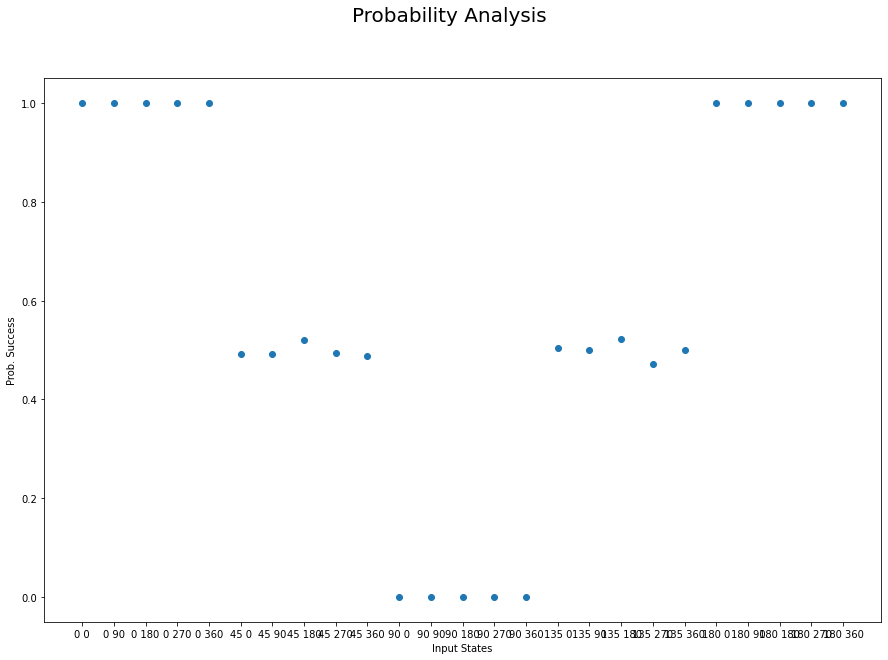

In [40]:
to_print = set_result_with_initial_states_and_psuccess(results)
plot_scatter(to_print['initial_states'], to_print['p_success'], 'Input States')

In [41]:
points_theta=5
points_phase=5
list_theta = np.mgrid[0:pi:points_theta * 1j]
list_phase = np.mgrid[0:2 * pi:points_phase * 1j]
list_eta = [0, pi/4/2]
list_phi_rx = [0]
list_phi_ry = [0]

global_configuration = {
    'list_theta': list_theta,
    'list_phase': list_phase,
    'list_phi_rx': list_phi_rx,
    'list_phi_ry': list_phi_ry,
    'list_eta': list_eta,
}

backend = Aer.get_backend('qasm_simulator')
plays = 10
results = play_all_configurations(global_configuration, backend, plays)

Starting the execution
execution with theta 0.0
total minutes taken this theta:  0
total minutes taken so far:  0
execution with theta 0.7853981633974483
total minutes taken this theta:  0
total minutes taken so far:  1
execution with theta 1.5707963267948966
total minutes taken this theta:  0
total minutes taken so far:  1
execution with theta 2.356194490192345
total minutes taken this theta:  0
total minutes taken so far:  2
execution with theta 3.141592653589793
total minutes taken this theta:  0
total minutes taken so far:  2
total minutes of execution time:  2
All guesses have been calculated
Total configurations tested: 25


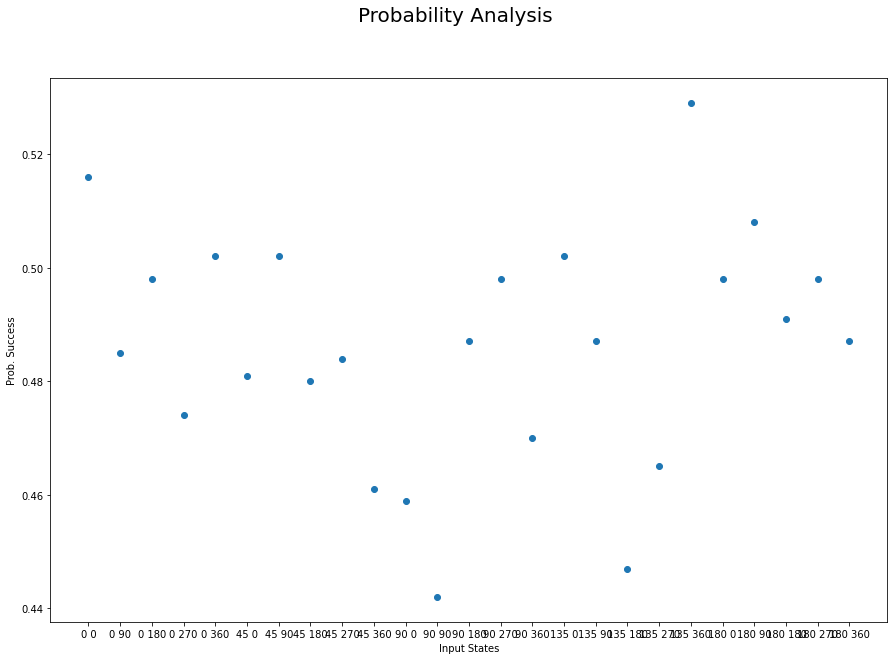

In [42]:
to_print = set_result_with_initial_states_and_psuccess(results)
plot_scatter(to_print['initial_states'], to_print['p_success'], 'Input States')